In [28]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [29]:
data_dir = "../data"
image_size = (64, 64)
labels = ['aeyn', 'alif', 'alif_lam', 'ba2', 'daal', 'dha2', 'dhaad', 'fa2', 'gaf', 'ghayn', 'haa', 'haa2', 'jeeem', 'kaaaf', 'khaaa', 'laa', 'laaam', 'meeem', 'nuun', 'ra2', 'saaad', 'seeen', 'sheeen', 'ta2', 'taa', 'thaaa', 'thaal', 'toott', 'waaw', 'yaa', 'yaa2', 'zaay']


In [30]:
images = []
labels_list = []

for label in labels:
    label_dir = os.path.join(data_dir, label)
    for image_name in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        image = load_img(image_path, color_mode='grayscale', target_size=image_size)
        image_array = img_to_array(image)
        images.append(image_array)
        labels_list.append(label)

images = np.array(images)
labels_list = np.array(labels_list)

In [31]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_list)

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotate images by 20 degrees
    width_shift_range=0.1,  # Horizontal shift by 10%
    height_shift_range=0.1, # Vertical shift by 10%
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Zoom in/out by 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill empty pixels with nearest values
)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [34]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (34601, 64, 64, 1)
y_train shape: (34601,)
x_test shape: (8651, 64, 64, 1)
y_test shape: (8651,)


In [35]:
# Fit the generator to the training data
datagen.fit(x_train)

In [36]:
import matplotlib.pyplot as plt
def plot_samples(x, y, indices):
    n = len(indices)
    plt.figure(figsize=(15, 5))
    for i, index in enumerate(indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(x[index])
        plt.xlabel(labels[y[index]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

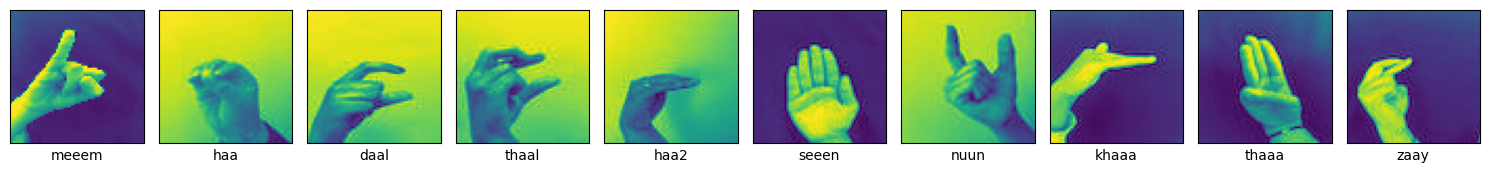

In [37]:
plot_samples(x_train,y_train,[i for i in range(10)])

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
    Dense, Dropout, BatchNormalization, Input
)

def model(input_shape=(64, 64, 1), num_classes=32):
    inputs = Input(shape=input_shape)
    
    # First convolutional block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Second convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Third convolutional block (added for deeper feature extraction)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Fourth convolutional block (extra depth for complex features)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Global Average Pooling instead of Flatten
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = model(input_shape=(64, 64, 1), num_classes=len(labels))

In [39]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 64)        256 

In [41]:
# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=17
)

Epoch 1/17
1082/1082 [==============================] - 215s 198ms/step - loss: 2.3326 - accuracy: 0.2585 - val_loss: 1.5002 - val_accuracy: 0.4935
Epoch 2/17
1082/1082 [==============================] - 220s 203ms/step - loss: 1.3625 - accuracy: 0.5337 - val_loss: 0.9189 - val_accuracy: 0.7042
Epoch 3/17
1082/1082 [==============================] - 213s 197ms/step - loss: 0.9542 - accuracy: 0.6824 - val_loss: 7.2620 - val_accuracy: 0.1559
Epoch 4/17
1082/1082 [==============================] - 214s 197ms/step - loss: 0.7464 - accuracy: 0.7549 - val_loss: 3.7293 - val_accuracy: 0.2147
Epoch 5/17
1082/1082 [==============================] - 214s 198ms/step - loss: 0.6207 - accuracy: 0.7970 - val_loss: 0.2785 - val_accuracy: 0.9060
Epoch 6/17
1082/1082 [==============================] - 213s 197ms/step - loss: 0.5544 - accuracy: 0.8201 - val_loss: 0.3639 - val_accuracy: 0.8872
Epoch 7/17
1082/1082 [==============================] - 214s 198ms/step - loss: 0.4998 - accuracy: 0.8415 - val_

In [42]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

271/271 [==============================] - 16s 58ms/step - loss: 0.6758 - accuracy: 0.8053
Test accuracy: 0.8053404092788696


In [43]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
def save_model_h5(model, filepath='../models/arabic_letters_model.h5'):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    model.save(filepath, save_format='h5')
    print(f"Module sauvegarde avec succus au format h5: {filepath}")
    
    return filepath
save_model_h5(model=model)

Module sauvegarde avec succus au format h5: ../models/arabic_letters_model.h5


c:\Users\raid benlala\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'../models/arabic_letters_model.h5'

In [44]:
y_pred = model.predict(x_test)

271/271 [==============================] - 18s 64ms/step


In [45]:
import numpy as np
print(y_test[:10])
print([np.argmax(item) for item in y_pred[:10]])

[ 8 30 22 15 18 16 15  4  6 29]
[8, 28, 22, 23, 18, 16, 15, 12, 28, 29]


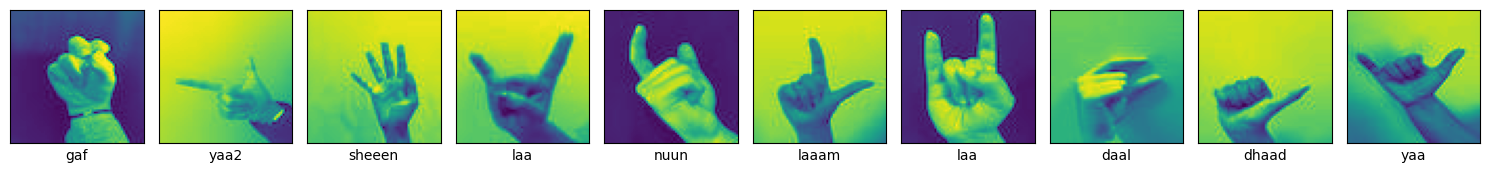

In [46]:
plot_samples(x_test[:10], y_test[:10], [i for i in range(10)])